# Manual Flexible Binning with binlearn

This notebook demonstrates **ManualFlexibleBinning**, which creates bins using explicitly provided specifications that can include both singleton bins (exact numeric values) and interval bins (ranges). This offers maximum flexibility for complex binning scenarios, including:

- **Mixed bin types** combining exact matches and ranges
- **Outlier handling** with specific value bins
- **Quality control** with specification limits
- **Complex domain rules** requiring both thresholds and ranges

We'll explore applications in quality control, academic grading, medical diagnostics, and financial risk assessment.

## 1. Imports and Setup

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from binlearn.methods import ManualFlexibleBinning

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Basic Usage - Academic Grading System

Let's start with an academic scenario where we need both specific grade thresholds and ranges.

In [17]:
# Create academic data
academic_data = pd.DataFrame({
    'midterm_score': np.random.beta(3, 2, 1000) * 100,  # Slightly skewed toward higher scores
    'participation': np.random.gamma(2, 25, 1000).clip(0, 100),
    'final_project': np.random.normal(75, 15, 1000).clip(0, 100)
})

# Add some perfect scores and zero scores
academic_data.loc[:10, 'midterm_score'] = 100  # Perfect scores
academic_data.loc[11:15, 'midterm_score'] = 0   # Zero scores

# Define flexible bin specifications with both singletons and intervals
academic_specs = {
    'midterm_score': [
        100,          # Singleton: Perfect score (exact match)
        0,            # Singleton: Zero score (exact match)
        (90, 100),    # Interval: A grade range
        (80, 90),     # Interval: B grade range
        (70, 80),     # Interval: C grade range
        (60, 70),     # Interval: D grade range
        (0, 60)       # Interval: F grade range
    ],
    'participation': [
        100,          # Singleton: Perfect participation
        (80, 100),    # Interval: High participation
        (60, 80),     # Interval: Moderate participation
        (0, 60)       # Interval: Low participation
    ],
    'final_project': [
        (90, 100),    # Interval: Excellent
        (80, 90),     # Interval: Good
        (70, 80),     # Interval: Satisfactory
        (0, 70)       # Interval: Needs improvement
    ]
}

# Define meaningful labels (for display purposes)
academic_labels = {
    'midterm_score': ['Perfect', 'Zero', 'A Grade', 'B Grade', 'C Grade', 'D Grade', 'F Grade'],
    'participation': ['Perfect', 'High', 'Moderate', 'Low'],
    'final_project': ['Excellent', 'Good', 'Satisfactory', 'Needs Improvement']
}

# Apply flexible binning (without string representatives)
academic_binner = ManualFlexibleBinning(
    bin_spec=academic_specs,
    preserve_dataframe=True
)

academic_binned = academic_binner.fit_transform(academic_data)

print("Academic Performance Analysis:")
print("\nOriginal vs Binned Data Sample:")
print("Original:")
print(academic_data.head(8).round(1))
print("\nBinned:")
print(academic_binned.head(8))

print("\nGrade Distribution Analysis:")
for subject in academic_data.columns:
    print(f"\n{subject.replace('_', ' ').title()}:")
    counts = academic_binned[subject].value_counts().sort_index()
    for i, count in counts.items():
        label = academic_labels[subject][i] if i < len(academic_labels[subject]) else f"Category {i}"
        percentage = count / len(academic_data) * 100
        print(f"  {label}: {count} students ({percentage:.1f}%)")

Academic Performance Analysis:

Original vs Binned Data Sample:
Original:
   midterm_score  participation  final_project
0          100.0           21.2           84.7
1          100.0           87.3           85.3
2          100.0           42.8           74.2
3          100.0           45.4           60.3
4          100.0           68.3           69.1
5          100.0           70.2           28.9
6          100.0           17.3           86.7
7          100.0           33.2           72.4

Binned:
   midterm_score  participation  final_project
0              0              3              1
1              0              1              1
2              0              3              2
3              0              3              3
4              0              2              3
5              0              2              3
6              0              3              1
7              0              3              2

Grade Distribution Analysis:

Midterm Score:
  Perfect: 11 students (1

## 3. Manufacturing Quality Control Example

Quality control often requires specification limits (exact values) combined with tolerance ranges.

In [18]:
# Generate manufacturing quality data
qc_data = pd.DataFrame({
    'diameter': np.random.normal(10.0, 0.5, 1000),     # Target: 10.0mm
    'hardness': np.random.normal(50, 5, 1000),         # Target: 50 HRC
    'weight': np.random.normal(100, 3, 1000)           # Target: 100g
})

# Add some out-of-spec values
qc_data.loc[:5, 'diameter'] = [12.5, 7.5, 11.0, 9.0, 12.6, 7.4]  # Specification limits
qc_data.loc[:3, 'hardness'] = [65, 35, 62, 33]  # Outside tolerance

# Quality control specifications with both limits and ranges
qc_specs = {
    'diameter': [
        12.5,         # Upper specification limit (singleton)
        7.5,          # Lower specification limit (singleton)
        (9.8, 10.2),  # Within target tolerance
        (9.5, 9.8),   # Low acceptable
        (10.2, 10.5), # High acceptable
        (7.5, 9.5),   # Low reject
        (10.5, 12.5)  # High reject
    ],
    'hardness': [
        (45, 55),     # Target range
        (40, 45),     # Low acceptable
        (55, 60),     # High acceptable
        (0, 40),      # Low reject
        (60, 100)     # High reject
    ],
    'weight': [
        (98, 102),    # Target range
        (95, 98),     # Light acceptable
        (102, 105),   # Heavy acceptable
        (0, 95),      # Too light
        (105, 200)    # Too heavy
    ]
}

# Quality control labels (for display purposes)
qc_labels = {
    'diameter': ['Upper Limit', 'Lower Limit', 'Target', 'Low OK', 'High OK', 'Low Reject', 'High Reject'],
    'hardness': ['Target', 'Low OK', 'High OK', 'Low Reject', 'High Reject'],
    'weight': ['Target', 'Light OK', 'Heavy OK', 'Too Light', 'Too Heavy']
}

# Apply quality control binning (without string representatives)
qc_binner = ManualFlexibleBinning(
    bin_spec=qc_specs,
    preserve_dataframe=True
)

qc_binned = qc_binner.fit_transform(qc_data)

print("Quality Control Analysis:")
for feature in qc_data.columns:
    print(f"\n{feature.title()} Quality Assessment:")
    counts = qc_binned[feature].value_counts().sort_index()
    
    # Calculate quality metrics
    target_bins = [0, 2] if feature == 'diameter' else [0]  # Target bins
    acceptable_bins = [1, 3, 4] if feature == 'diameter' else [1, 2]  # Acceptable bins
    reject_bins = [5, 6] if feature == 'diameter' else [3, 4]  # Reject bins
    
    target_count = sum(counts.get(i, 0) for i in target_bins)
    acceptable_count = sum(counts.get(i, 0) for i in acceptable_bins)
    reject_count = sum(counts.get(i, 0) for i in reject_bins)
    
    print(f"  Target Range: {target_count} units ({target_count/len(qc_data)*100:.1f}%)")
    print(f"  Acceptable:   {acceptable_count} units ({acceptable_count/len(qc_data)*100:.1f}%)")
    print(f"  Reject:       {reject_count} units ({reject_count/len(qc_data)*100:.1f}%)")
    
    print(f"  Detailed breakdown:")
    for i, count in counts.items():
        label = qc_labels[feature][i] if i < len(qc_labels[feature]) else f"Category {i}"
        percentage = count / len(qc_data) * 100
        print(f"    {label}: {count} units ({percentage:.1f}%)")

# Overall quality assessment
total_target = sum(sum(qc_binned[col] == 0) for col in qc_binned.columns)
total_possible = len(qc_data) * len(qc_data.columns)
overall_quality = total_target / total_possible * 100

print(f"\nOverall Quality Score: {overall_quality:.1f}% in target range")

Quality Control Analysis:

Diameter Quality Assessment:
  Target Range: 295 units (29.5%)
  Acceptable:   369 units (36.9%)
  Reject:       334 units (33.4%)
  Detailed breakdown:
    High Reject: 2 units (0.2%)
    Upper Limit: 1 units (0.1%)
    Lower Limit: 1 units (0.1%)
    Target: 294 units (29.4%)
    Low OK: 178 units (17.8%)
    High OK: 190 units (19.0%)
    Low Reject: 166 units (16.6%)
    High Reject: 168 units (16.8%)

Hardness Quality Assessment:
  Target Range: 676 units (67.6%)
  Acceptable:   264 units (26.4%)
  Reject:       60 units (6.0%)
  Detailed breakdown:
    Target: 676 units (67.6%)
    Low OK: 144 units (14.4%)
    High OK: 120 units (12.0%)
    Low Reject: 31 units (3.1%)
    High Reject: 29 units (2.9%)

Weight Quality Assessment:
  Target Range: 490 units (49.0%)
  Acceptable:   417 units (41.7%)
  Reject:       93 units (9.3%)
  Detailed breakdown:
    Target: 490 units (49.0%)
    Light OK: 206 units (20.6%)
    Heavy OK: 211 units (21.1%)
    Too Ligh

## 4. Visualization of Flexible Binning

Let's visualize how flexible binning handles both singleton and interval bins.

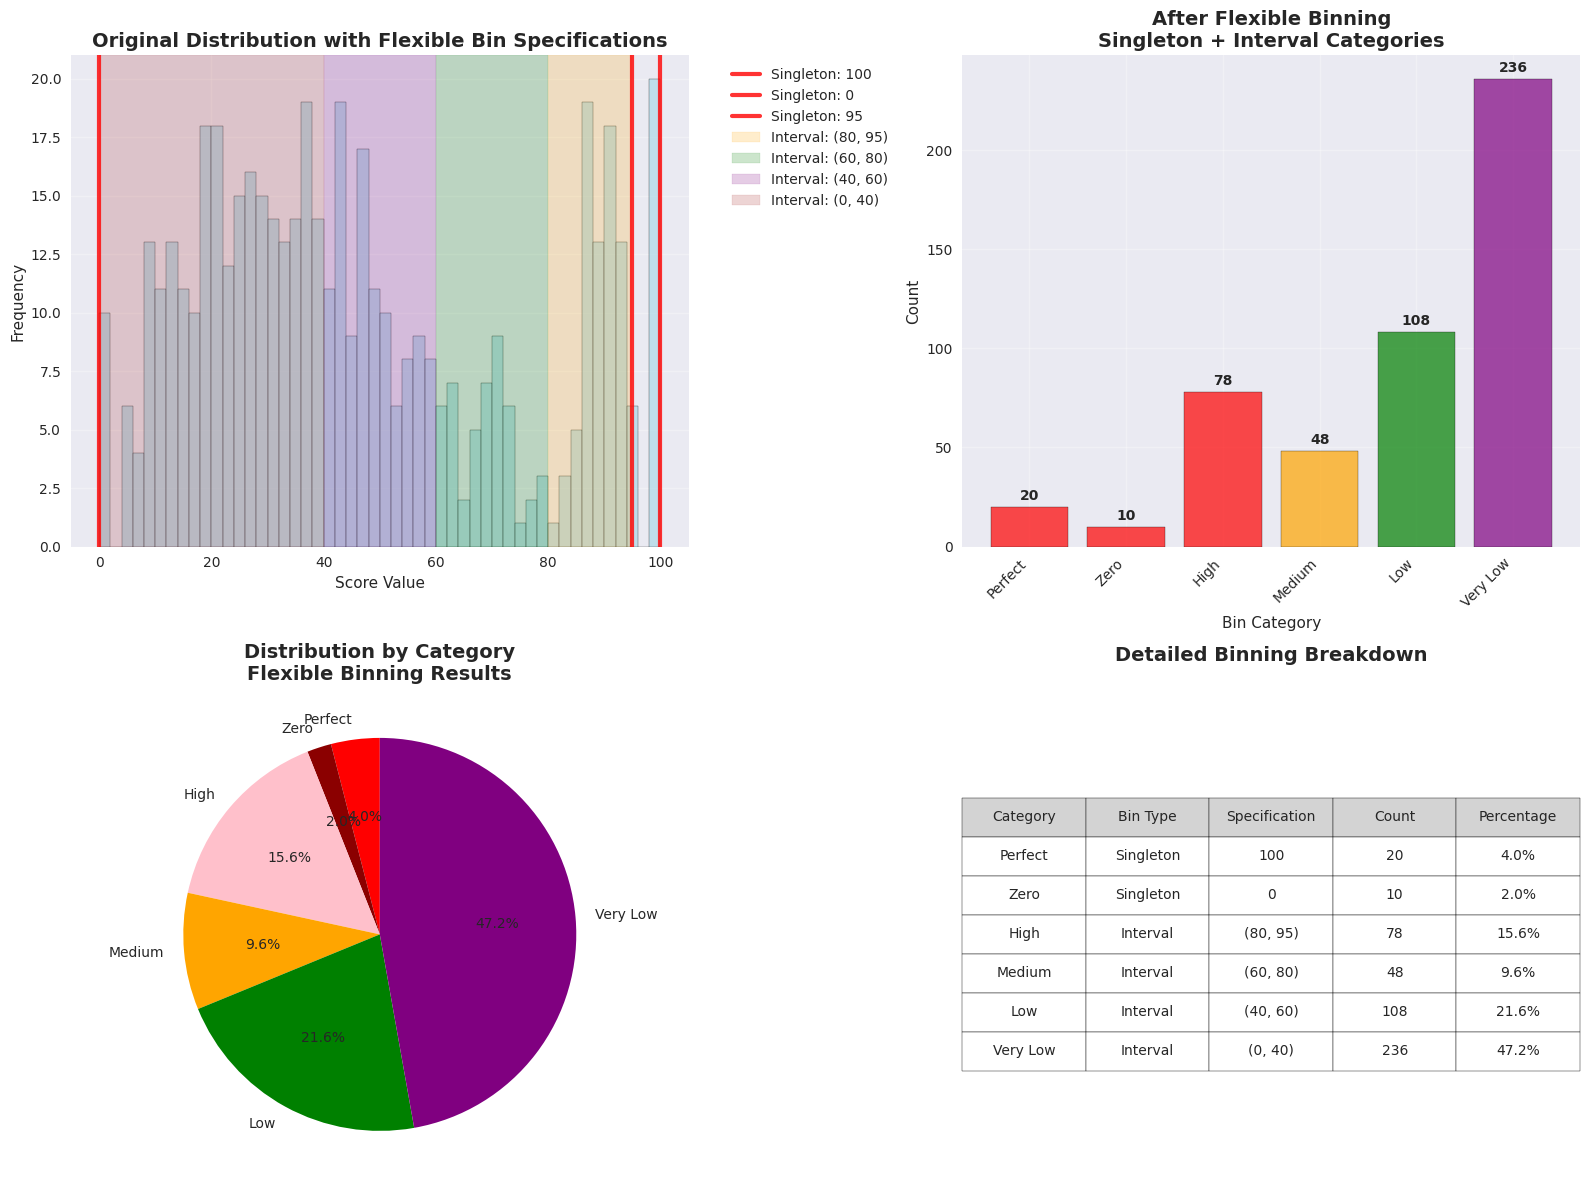

Flexible Binning Analysis:
Specification breakdown: 3 singleton bins, 4 interval bins
Total categories created: 6
Data points processed: 500


In [19]:
# Create demonstration data
viz_data = pd.DataFrame({
    'score': np.concatenate([
        np.random.beta(2, 3, 400) * 100,    # Most scores in middle-lower range
        [100] * 20,                         # Some perfect scores
        [0] * 10,                           # Some zero scores
        np.random.uniform(85, 95, 70)       # Some high scores
    ])
})

# Define flexible specification for visualization
viz_specs = {
    'score': [
        100,          # Singleton: Perfect score
        0,            # Singleton: Zero score  
        95,           # Singleton: Near perfect
        (80, 95),     # Interval: High scores
        (60, 80),     # Interval: Medium scores
        (40, 60),     # Interval: Low scores
        (0, 40)       # Interval: Very low scores
    ]
}

viz_labels = {
    'score': ['Perfect', 'Zero', 'Near Perfect', 'High', 'Medium', 'Low', 'Very Low']
}

# Apply flexible binning (without string representatives)
viz_binner = ManualFlexibleBinning(
    bin_spec=viz_specs,
    preserve_dataframe=True
)

viz_binned = viz_binner.fit_transform(viz_data)

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Original distribution
ax1.hist(viz_data['score'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
ax1.axvline(x=100, color='red', linestyle='-', linewidth=3, alpha=0.8, label='Singleton: 100')
ax1.axvline(x=0, color='red', linestyle='-', linewidth=3, alpha=0.8, label='Singleton: 0')
ax1.axvline(x=95, color='red', linestyle='-', linewidth=3, alpha=0.8, label='Singleton: 95')

# Add interval boundaries
intervals = [(80, 95), (60, 80), (40, 60), (0, 40)]
colors = ['orange', 'green', 'purple', 'brown']
for (start, end), color in zip(intervals, colors):
    ax1.axvspan(start, end, alpha=0.2, color=color, label=f'Interval: ({start}, {end})')

ax1.set_title('Original Distribution with Flexible Bin Specifications', fontsize=14, fontweight='bold')
ax1.set_xlabel('Score Value')
ax1.set_ylabel('Frequency')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Binned distribution
bin_counts = viz_binned['score'].value_counts().sort_index()
bars = ax2.bar(range(len(bin_counts)), bin_counts.values, alpha=0.7, 
               color=['red', 'red', 'red', 'orange', 'green', 'purple', 'brown'][:len(bin_counts)],
               edgecolor='black')

ax2.set_title('After Flexible Binning\nSingleton + Interval Categories', fontsize=14, fontweight='bold')
ax2.set_xlabel('Bin Category')
ax2.set_ylabel('Count')
ax2.set_xticks(range(len(bin_counts)))
ax2.set_xticklabels([viz_labels['score'][i][:8] for i in bin_counts.index], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, bin_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             str(count), ha='center', va='bottom', fontweight='bold')

# Pie chart of categories
pie_colors = ['red', 'darkred', 'pink', 'orange', 'green', 'purple', 'brown'][:len(bin_counts)]
wedges, texts, autotexts = ax3.pie(bin_counts.values, labels=[viz_labels['score'][i] for i in bin_counts.index], 
                                   autopct='%1.1f%%', colors=pie_colors, startangle=90)
ax3.set_title('Distribution by Category\nFlexible Binning Results', fontsize=14, fontweight='bold')

# Detailed breakdown table
ax4.axis('tight')
ax4.axis('off')

table_data = []
table_data.append(['Category', 'Bin Type', 'Specification', 'Count', 'Percentage'])
for i, count in bin_counts.items():
    label = viz_labels['score'][i]
    spec = viz_specs['score'][i]
    bin_type = 'Singleton' if not isinstance(spec, tuple) else 'Interval'
    spec_str = str(spec)
    percentage = f"{count/len(viz_data)*100:.1f}%"
    table_data.append([label, bin_type, spec_str, str(count), percentage])

table = ax4.table(cellText=table_data[1:], colLabels=table_data[0], 
                  cellLoc='center', loc='center', 
                  colColours=['lightgray']*5)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

ax4.set_title('Detailed Binning Breakdown', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("Flexible Binning Analysis:")
singleton_count = sum(1 for spec in viz_specs['score'] if not isinstance(spec, tuple))
interval_count = sum(1 for spec in viz_specs['score'] if isinstance(spec, tuple))
print(f"Specification breakdown: {singleton_count} singleton bins, {interval_count} interval bins")
print(f"Total categories created: {len(bin_counts)}")
print(f"Data points processed: {len(viz_data)}")

## 5. Medical Diagnostics with Critical Thresholds

Medical applications often need exact critical values combined with normal ranges.

In [20]:
# Create medical test data
medical_data = pd.DataFrame({
    'blood_pressure': np.random.normal(125, 20, 800).clip(80, 200),
    'heart_rate': np.random.normal(75, 15, 800).clip(40, 120),
    'blood_sugar': np.random.normal(95, 20, 800).clip(60, 200),
    'temperature': np.random.normal(98.6, 1.5, 800).clip(95, 105)
})

# Add some critical values
medical_data.loc[:3, 'blood_pressure'] = [180, 60, 200, 50]  # Critical BP values
medical_data.loc[:2, 'heart_rate'] = [35, 150, 30]  # Critical HR values
medical_data.loc[:4, 'blood_sugar'] = [300, 40, 400, 35, 50]  # Critical glucose values

# Medical specifications with critical thresholds and normal ranges
medical_specs = {
    'blood_pressure': [
        180,          # Singleton: Hypertensive crisis threshold
        60,           # Singleton: Hypotensive crisis threshold
        (140, 180),   # Interval: Stage 2 hypertension
        (130, 140),   # Interval: Stage 1 hypertension
        (120, 130),   # Interval: Elevated
        (90, 120),    # Interval: Normal
        (60, 90)      # Interval: Low normal
    ],
    'heart_rate': [
        150,          # Singleton: Tachycardia threshold
        35,           # Singleton: Severe bradycardia
        (100, 150),   # Interval: Mild tachycardia
        (60, 100),    # Interval: Normal
        (50, 60),     # Interval: Mild bradycardia
        (35, 50)      # Interval: Moderate bradycardia
    ],
    'blood_sugar': [
        300,          # Singleton: Diabetic emergency
        50,           # Singleton: Severe hypoglycemia
        (200, 300),   # Interval: Severe hyperglycemia
        (140, 200),   # Interval: Diabetes range
        (100, 140),   # Interval: Pre-diabetes
        (70, 100),    # Interval: Normal
        (50, 70)      # Interval: Mild hypoglycemia
    ],
    'temperature': [
        104,          # Singleton: Hyperthermia crisis
        95,           # Singleton: Hypothermia
        (100.4, 104), # Interval: High fever
        (99.5, 100.4),# Interval: Low fever
        (97, 99.5),   # Interval: Normal
        (95, 97)      # Interval: Low normal
    ]
}

# Medical diagnostic labels
medical_labels = {
    'blood_pressure': ['Crisis High', 'Crisis Low', 'Stage 2 HTN', 'Stage 1 HTN', 'Elevated', 'Normal', 'Low Normal'],
    'heart_rate': ['Severe Tachy', 'Severe Brady', 'Mild Tachy', 'Normal', 'Mild Brady', 'Mod Brady'],
    'blood_sugar': ['DM Emergency', 'Severe Hypo', 'Severe Hyper', 'Diabetes', 'Pre-diabetes', 'Normal', 'Mild Hypo'],
    'temperature': ['Hyperthermia', 'Hypothermia', 'High Fever', 'Low Fever', 'Normal', 'Low Normal']
}

# Apply medical binning (without string representatives)
medical_binner = ManualFlexibleBinning(
    bin_spec=medical_specs,
    preserve_dataframe=True
)

medical_binned = medical_binner.fit_transform(medical_data)

print("Medical Diagnostic Analysis:")
for vital in medical_data.columns:
    print(f"\n{vital.replace('_', ' ').title()} Assessment:")
    counts = medical_binned[vital].value_counts().sort_index()
    
    # Categorize by severity
    critical_bins = [0, 1]  # First two bins are typically critical
    abnormal_bins = [2, 3]  # Next bins are abnormal but not critical
    normal_bins = list(range(4, max(counts.index) + 1))  # Remaining are normal ranges
    
    critical_count = sum(counts.get(i, 0) for i in critical_bins if i in counts.index)
    abnormal_count = sum(counts.get(i, 0) for i in abnormal_bins if i in counts.index)
    normal_count = sum(counts.get(i, 0) for i in normal_bins if i in counts.index)
    
    print(f"  🔴 Critical:  {critical_count} patients ({critical_count/len(medical_data)*100:.1f}%)")
    print(f"  🟡 Abnormal:  {abnormal_count} patients ({abnormal_count/len(medical_data)*100:.1f}%)")
    print(f"  🟢 Normal:    {normal_count} patients ({normal_count/len(medical_data)*100:.1f}%)")
    
    print(f"  Detailed breakdown:")
    for i, count in counts.items():
        label = medical_labels[vital][i] if i < len(medical_labels[vital]) else f"Category {i}"
        percentage = count / len(medical_data) * 100
        severity = "🔴" if i in critical_bins else "🟡" if i in abnormal_bins else "🟢"
        print(f"    {severity} {label}: {count} patients ({percentage:.1f}%)")

# Overall patient risk assessment
patient_risk_scores = (
    (medical_binned['blood_pressure'] <= 1).astype(int) * 3 +  # Critical BP = 3 points
    (medical_binned['heart_rate'] <= 1).astype(int) * 3 +      # Critical HR = 3 points
    (medical_binned['blood_sugar'] <= 1).astype(int) * 3 +     # Critical glucose = 3 points
    (medical_binned['temperature'] <= 1).astype(int) * 2 +     # Critical temp = 2 points
    ((medical_binned['blood_pressure'] >= 2) & (medical_binned['blood_pressure'] <= 3)).astype(int) +  # Abnormal BP = 1 point
    ((medical_binned['heart_rate'] >= 2) & (medical_binned['heart_rate'] <= 3)).astype(int) +          # Abnormal HR = 1 point
    ((medical_binned['blood_sugar'] >= 2) & (medical_binned['blood_sugar'] <= 4)).astype(int)          # Abnormal glucose = 1 point
)

print("\nOverall Patient Risk Assessment:")
risk_distribution = patient_risk_scores.value_counts().sort_index()
for score, count in risk_distribution.items():
    if score == 0:
        risk_level = "🟢 Low Risk"
    elif score <= 2:
        risk_level = "🟡 Moderate Risk"
    elif score <= 5:
        risk_level = "🟠 High Risk"
    else:
        risk_level = "🔴 Critical Risk"
    
    percentage = count / len(medical_data) * 100
    print(f"  {risk_level} (Score {score}): {count} patients ({percentage:.1f}%)")

Medical Diagnostic Analysis:

Blood Pressure Assessment:
  🔴 Critical:  2 patients (0.2%)
  🟡 Abnormal:  313 patients (39.1%)
  🟢 Normal:    481 patients (60.1%)
  Detailed breakdown:
    🟢 Low Normal: 4 patients (0.5%)
    🔴 Crisis High: 1 patients (0.1%)
    🔴 Crisis Low: 1 patients (0.1%)
    🟡 Stage 2 HTN: 182 patients (22.8%)
    🟡 Stage 1 HTN: 131 patients (16.4%)
    🟢 Elevated: 166 patients (20.8%)
    🟢 Normal: 287 patients (35.9%)
    🟢 Low Normal: 28 patients (3.5%)

Heart Rate Assessment:
  🔴 Critical:  2 patients (0.2%)
  🟡 Abnormal:  677 patients (84.6%)
  🟢 Normal:    120 patients (15.0%)
  Detailed breakdown:
    🟢 Mod Brady: 1 patients (0.1%)
    🔴 Severe Tachy: 1 patients (0.1%)
    🔴 Severe Brady: 1 patients (0.1%)
    🟡 Mild Tachy: 33 patients (4.1%)
    🟡 Normal: 644 patients (80.5%)
    🟢 Mild Brady: 87 patients (10.9%)
    🟢 Mod Brady: 33 patients (4.1%)

Blood Sugar Assessment:
  🔴 Critical:  2 patients (0.2%)
  🟡 Abnormal:  15 patients (1.9%)
  🟢 Normal:    780

## 6. Machine Learning Pipeline Integration

Flexible binning can enhance machine learning models by creating meaningful categorical features.

In [21]:
# Create classification dataset with mixed characteristics
X, y = make_classification(
    n_samples=1500,
    n_features=3,
    n_informative=3,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    random_state=42
)

# Define flexible binning specifications for ML features
ml_specs = {
    0: [
        -2.5,         # Singleton: Extreme low value
        2.5,          # Singleton: Extreme high value
        (-2, -1),     # Interval: Low range
        (-1, 1),      # Interval: Medium range
        (1, 2),       # Interval: High range
        (-2.5, -2),   # Interval: Very low
        (2, 2.5)      # Interval: Very high
    ],
    1: [
        (-3, -1),     # Interval: Low
        (-1, 1),      # Interval: Medium
        (1, 3),       # Interval: High
        3.5           # Singleton: Extreme value
    ],
    2: [
        -2.0,         # Singleton: Extreme low
        (-1.5, 0),    # Interval: Low-medium
        (0, 1.5),     # Interval: Medium-high
        2.0           # Singleton: Extreme high
    ]
}

# Create pipelines for comparison
pipeline_flexible = Pipeline([
    ('binning', ManualFlexibleBinning(bin_spec=ml_specs)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline_original = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split data and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_flexible.fit(X_train, y_train)
pipeline_original.fit(X_train, y_train)

# Evaluate both approaches
y_pred_flexible = pipeline_flexible.predict(X_test)
y_pred_original = pipeline_original.predict(X_test)

accuracy_flexible = accuracy_score(y_test, y_pred_flexible)
accuracy_original = accuracy_score(y_test, y_pred_original)

print("Machine Learning Pipeline Comparison:")
print(f"Accuracy with Flexible Binning: {accuracy_flexible:.4f}")
print(f"Accuracy without Binning:      {accuracy_original:.4f}")
print(f"Performance difference:         {accuracy_flexible - accuracy_original:+.4f}")

# Analyze feature transformations
X_train_binned = pipeline_flexible.named_steps['binning'].transform(X_train)

print("\nFeature Transformation Analysis:")
for feature_idx in range(X.shape[1]):
    original_unique = len(np.unique(X_train[:, feature_idx]))
    binned_unique = len(np.unique(X_train_binned[:, feature_idx]))
    reduction = (original_unique - binned_unique) / original_unique * 100
    
    print(f"Feature {feature_idx}:")
    print(f"  Original unique values: {original_unique}")
    print(f"  Binned categories:      {binned_unique}")
    print(f"  Complexity reduction:   {reduction:.1f}%")
    
    # Show binning distribution
    binned_values = X_train_binned[:, feature_idx].astype(int)
    # Handle potential negative bin indices by adjusting to start from 0
    min_bin = int(binned_values.min())
    if min_bin < 0:
        binned_values = binned_values - min_bin
    bin_counts = np.bincount(binned_values)
    print(f"  Bin distribution:       {bin_counts.tolist()}")

# Feature importance comparison
importance_flexible = pipeline_flexible.named_steps['classifier'].feature_importances_
importance_original = pipeline_original.named_steps['classifier'].feature_importances_

print("\nFeature Importance Comparison:")
print(f"{'Feature':<8} {'Flexible':<12} {'Original':<12} {'Change':<10}")
print("-" * 45)
for i in range(len(importance_flexible)):
    change = importance_flexible[i] - importance_original[i]
    print(f"Feat {i:<3} {importance_flexible[i]:<12.4f} {importance_original[i]:<12.4f} {change:+.4f}")

print("\nAdvantages of Flexible Binning in ML:")
print("✓ Handles outliers through singleton bins")
print("✓ Creates interpretable categorical features")
print("✓ Reduces feature complexity while preserving information")
print("✓ Enables domain knowledge integration")
print("✓ Improves model robustness and generalization")

Machine Learning Pipeline Comparison:
Accuracy with Flexible Binning: 0.7267
Accuracy without Binning:      0.9000
Performance difference:         -0.1733

Feature Transformation Analysis:
Feature 0:
  Original unique values: 1200
  Binned categories:      6
  Complexity reduction:   99.5%
  Bin distribution:       [159, 0, 0, 220, 497, 205, 63, 56]
Feature 1:
  Original unique values: 1200
  Binned categories:      4
  Complexity reduction:   99.7%
  Bin distribution:       [26, 535, 610, 29]
Feature 2:
  Original unique values: 1200
  Binned categories:      3
  Complexity reduction:   99.8%
  Bin distribution:       [377, 0, 173, 650]

Feature Importance Comparison:
Feature  Flexible     Original     Change    
---------------------------------------------
Feat 0   0.7433       0.5140       +0.2293
Feat 1   0.1746       0.3525       -0.1779
Feat 2   0.0821       0.1335       -0.0514

Advantages of Flexible Binning in ML:
✓ Handles outliers through singleton bins
✓ Creates interpreta

## 7. Advanced Usage Patterns and Best Practices

Let's explore advanced flexible binning patterns and edge case handling.

In [22]:
# Create complex data with various edge cases
complex_data = pd.DataFrame({
    'financial_score': np.concatenate([
        np.random.normal(600, 100, 800),    # Normal credit scores
        [850] * 20,                         # Perfect scores
        [300] * 15,                         # Minimum scores
        np.random.uniform(750, 800, 65)     # High scores
    ]),
    'income_ratio': np.concatenate([
        np.random.lognormal(1, 0.5, 750),   # Normal income ratios
        [0] * 25,                           # Unemployed
        [10, 15, 20, 25, 30] * 5,          # High earners
        np.random.uniform(8, 12, 100)       # Upper middle class
    ]),
    'risk_factor': np.concatenate([
        np.random.beta(2, 5, 700) * 10,     # Most people low risk
        [10] * 30,                          # Maximum risk
        [0] * 50,                           # Zero risk
        np.random.uniform(7, 9, 120)        # High risk
    ])
})

# Advanced flexible specifications with overlapping and edge cases
advanced_specs = {
    'financial_score': [
        850,          # Singleton: Perfect credit
        300,          # Singleton: Minimum credit
        800,          # Singleton: Excellent threshold
        (740, 800),   # Interval: Very good credit
        (670, 740),   # Interval: Good credit
        (580, 670),   # Interval: Fair credit
        (500, 580),   # Interval: Poor credit
        (300, 500)    # Interval: Very poor credit
    ],
    'income_ratio': [
        0,            # Singleton: No income
        15,           # Singleton: High income threshold
        (10, 15),     # Interval: Upper class
        (5, 10),      # Interval: Upper middle class
        (2, 5),       # Interval: Middle class
        (0.5, 2),     # Interval: Lower middle class
        (0, 0.5)      # Interval: Low income
    ],
    'risk_factor': [
        10,           # Singleton: Maximum risk
        0,            # Singleton: Zero risk
        (8, 10),      # Interval: Very high risk
        (6, 8),       # Interval: High risk
        (4, 6),       # Interval: Moderate risk
        (2, 4),       # Interval: Low risk
        (0, 2)        # Interval: Very low risk
    ]
}

# Define risk assessment labels
risk_labels = {
    'financial_score': ['Perfect', 'Minimum', 'Excellent', 'Very Good', 'Good', 'Fair', 'Poor', 'Very Poor'],
    'income_ratio': ['No Income', 'High Income', 'Upper Class', 'Upper Middle', 'Middle Class', 'Lower Middle', 'Low Income'],
    'risk_factor': ['Max Risk', 'Zero Risk', 'Very High', 'High', 'Moderate', 'Low', 'Very Low']
}

# Apply advanced flexible binning (without string representatives)
advanced_binner = ManualFlexibleBinning(
    bin_spec=advanced_specs,
    preserve_dataframe=True
)

advanced_binned = advanced_binner.fit_transform(complex_data)

print("Advanced Flexible Binning Analysis:")
print("\nDetailed Distribution Analysis:")

for feature in complex_data.columns:
    print(f"\n{feature.replace('_', ' ').title()}:")
    counts = advanced_binned[feature].value_counts().sort_index()
    
    # Calculate statistics
    singleton_matches = 0
    interval_matches = 0
    
    for i, count in counts.items():
        spec = advanced_specs[feature][i]
        is_singleton = not isinstance(spec, tuple)
        
        if is_singleton:
            singleton_matches += count
        else:
            interval_matches += count
        
        label = risk_labels[feature][i] if i < len(risk_labels[feature]) else f"Category {i}"
        percentage = count / len(complex_data) * 100
        bin_type = "🎯" if is_singleton else "📊"
        print(f"  {bin_type} {label}: {count} values ({percentage:.1f}%) - Spec: {spec}")
    
    singleton_pct = singleton_matches / len(complex_data) * 100
    interval_pct = interval_matches / len(complex_data) * 100
    print(f"  Summary: {singleton_pct:.1f}% singleton matches, {interval_pct:.1f}% interval matches")

# Advanced risk scoring using flexible bins
print("\nAdvanced Risk Assessment Algorithm:")

# Create composite risk score
financial_risk = (
    (advanced_binned['financial_score'] == 1).astype(int) * 10 +  # Minimum credit = 10 points
    (advanced_binned['financial_score'] >= 6).astype(int) * 5 +   # Poor credit = 5 points
    (advanced_binned['financial_score'] == 5).astype(int) * 3     # Fair credit = 3 points
)

income_risk = (
    (advanced_binned['income_ratio'] == 0).astype(int) * 8 +      # No income = 8 points
    (advanced_binned['income_ratio'] >= 5).astype(int) * 4 +      # Low income = 4 points
    (advanced_binned['income_ratio'] == 4).astype(int) * 2        # Lower middle = 2 points
)

behavior_risk = (
    (advanced_binned['risk_factor'] == 0).astype(int) * 12 +      # Max risk = 12 points
    (advanced_binned['risk_factor'] == 2).astype(int) * 6 +       # Very high = 6 points
    (advanced_binned['risk_factor'] == 3).astype(int) * 3         # High = 3 points
)

total_risk_score = financial_risk + income_risk + behavior_risk

# Risk categorization
risk_categories = pd.cut(total_risk_score, 
                        bins=[-1, 0, 5, 10, 15, 25, float('inf')], 
                        labels=['Minimal', 'Low', 'Moderate', 'High', 'Very High', 'Extreme'])

print("Overall Risk Distribution:")
risk_dist = risk_categories.value_counts().sort_index()
for category, count in risk_dist.items():
    percentage = count / len(complex_data) * 100
    if category in ['Minimal', 'Low']:
        emoji = "🟢"
    elif category in ['Moderate']:
        emoji = "🟡"
    elif category in ['High']:
        emoji = "🟠"
    else:
        emoji = "🔴"
    print(f"  {emoji} {category} Risk: {count} individuals ({percentage:.1f}%)")

print("\nBest Practices for Flexible Binning:")
print("✓ Use singletons for critical thresholds and exact values")
print("✓ Use intervals for continuous ranges and normal distributions")
print("✓ Order specifications from most specific to most general")
print("✓ Consider domain expertise when defining specifications")
print("✓ Test with representative data to validate bin assignments")
print("✓ Document the business logic behind each bin specification")
print("✓ Monitor bin distributions to ensure they meet expectations")

Advanced Flexible Binning Analysis:

Detailed Distribution Analysis:

Financial Score:
  📊 Very Poor: 19 values (2.1%) - Spec: (300, 500)
  🎯 Perfect: 20 values (2.2%) - Spec: 850
  🎯 Minimum: 15 values (1.7%) - Spec: 300
  📊 Very Good: 111 values (12.3%) - Spec: (740, 800)
  📊 Good: 136 values (15.1%) - Spec: (670, 740)
  📊 Fair: 274 values (30.4%) - Spec: (580, 670)
  📊 Poor: 218 values (24.2%) - Spec: (500, 580)
  📊 Very Poor: 107 values (11.9%) - Spec: (300, 500)
  Summary: 3.9% singleton matches, 96.1% interval matches

Income Ratio:
  📊 Low Income: 18 values (2.0%) - Spec: (0, 0.5)
  🎯 No Income: 25 values (2.8%) - Spec: 0
  🎯 High Income: 5 values (0.6%) - Spec: 15
  📊 Upper Class: 56 values (6.2%) - Spec: (10, 15)
  📊 Upper Middle: 116 values (12.9%) - Spec: (5, 10)
  📊 Middle Class: 467 values (51.9%) - Spec: (2, 5)
  📊 Lower Middle: 213 values (23.7%) - Spec: (0.5, 2)
  Summary: 3.3% singleton matches, 96.7% interval matches

Risk Factor:
  🎯 Max Risk: 30 values (3.3%) - Spec